In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.preprocessing import image_dataset_from_directory


In [3]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
directory = "/content/drive/MyDrive/asl_dataset"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.3,
                                             subset='training',
                                             seed=42, label_mode='categorical')
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.3,
                                             subset='validation',
                                             seed=42, label_mode='categorical')

Found 2515 files belonging to 36 classes.
Using 1761 files for training.
Found 2515 files belonging to 36 classes.
Using 754 files for validation.


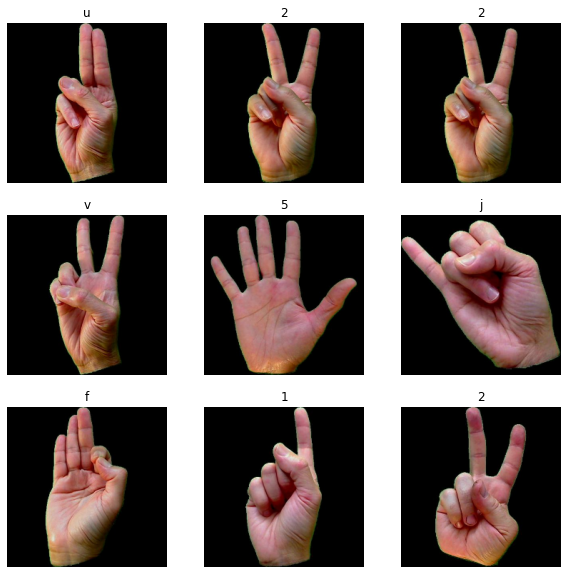

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [5]:
def data_augmenter():
  data_augmentation = tf.keras.Sequential()
  data_augmentation.add(RandomFlip('horizontal'))
  data_augmentation.add(RandomRotation(0.2))
  return data_augmentation


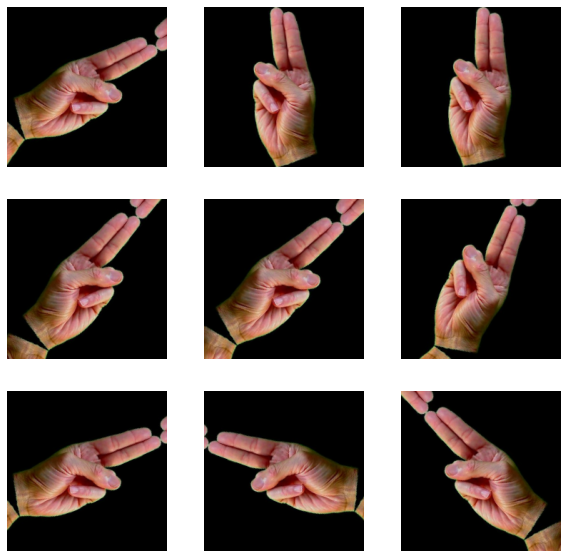

In [6]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [7]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [8]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

14548992/14536120 [==============================] - 0s 0us/step


In [9]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [10]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d
predictions


In [11]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
label_batch

(32, 1000)


<tf.Tensor: shape=(32, 36), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [12]:
base_model.trainable = False
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

49152/35363 [=========================================] - 0s 0us/step


[[('n01728920', 'ringneck_snake', 0.062788405),
  ('n03793489', 'mouse', 0.060313437)],
 [('n02786058', 'Band_Aid', 0.099765554), ('n03929660', 'pick', 0.08190135)],
 [('n02786058', 'Band_Aid', 0.31313848),
  ('n02777292', 'balance_beam', 0.13233176)],
 [('n02786058', 'Band_Aid', 0.8897287), ('n04423845', 'thimble', 0.02759394)],
 [('n02786058', 'Band_Aid', 0.52492285),
  ('n04423845', 'thimble', 0.051810347)],
 [('n01955084', 'chiton', 0.1959402), ('n01768244', 'trilobite', 0.035938267)],
 [('n02786058', 'Band_Aid', 0.876428),
  ('n03729826', 'matchstick', 0.012901609)],
 [('n02786058', 'Band_Aid', 0.14121677), ('n03627232', 'knot', 0.0803773)],
 [('n03929660', 'pick', 0.26012632), ('n03627232', 'knot', 0.06818622)],
 [('n02786058', 'Band_Aid', 0.09307103),
  ('n03729826', 'matchstick', 0.060395524)],
 [('n01728572', 'thunder_snake', 0.07798935),
  ('n02231487', 'walking_stick', 0.06516238)],
 [('n03929660', 'pick', 0.16352014), ('n02786058', 'Band_Aid', 0.12565792)],
 [('n02786058', 

In [18]:
def asl_model(image_shape = IMG_SIZE, data_augmentation = data_augmenter()):
  input_shape = image_shape + (3,)
  base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, #removes the top level layers; output layers
                                                   weights='imagenet') # From imageNet
  base_model.trainable = False
  inputs = tf.keras.Input(shape=input_shape)
  x = data_augmentation(inputs)
  x = preprocess_input(x) 
  x = base_model(x, training=False)
  x = tfl.Flatten()(x)
  prediction_layer = tfl.Dense(36,activation="softmax")
  outputs = prediction_layer(x)

  model = tf.keras.Model(inputs, outputs)
  return model



In [19]:
model = asl_model(IMG_SIZE, data_augmentation)

In [20]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                           

In [21]:
lr = 0.01
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [22]:
initial_epochs = 50
with tf.device('/device:GPU:1'):
    history = model.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/50
56/56 [==============================] - 683s 12s/step - loss: 8.1757 - accuracy: 0.4526 - val_loss: 4.2417 - val_accuracy: 0.6419
Epoch 2/50
56/56 [==============================] - 7s 108ms/step - loss: 2.9993 - accuracy: 0.7320 - val_loss: 2.0167 - val_accuracy: 0.7958
Epoch 3/50
56/56 [==============================] - 6s 106ms/step - loss: 2.4915 - accuracy: 0.7717 - val_loss: 3.7626 - val_accuracy: 0.7467
Epoch 4/50
56/56 [==============================] - 6s 106ms/step - loss: 2.7460 - accuracy: 0.7905 - val_loss: 2.3475 - val_accuracy: 0.8011
Epoch 5/50
56/56 [==============================] - 6s 106ms/step - loss: 1.9856 - accuracy: 0.8348 - val_loss: 2.5630 - val_accuracy: 0.8501
Epoch 6/50
56/56 [==============================] - 6s 105ms/step - loss: 1.8274 - accuracy: 0.8694 - val_loss: 2.1679 - val_accuracy: 0.8554
Epoch 7/50
56/56 [==============================] - 6s 106ms/step - loss: 1.9981 - accuracy: 0.8586 - val_loss: 2.0183 - val_accuracy: 0.8302
Epoch 

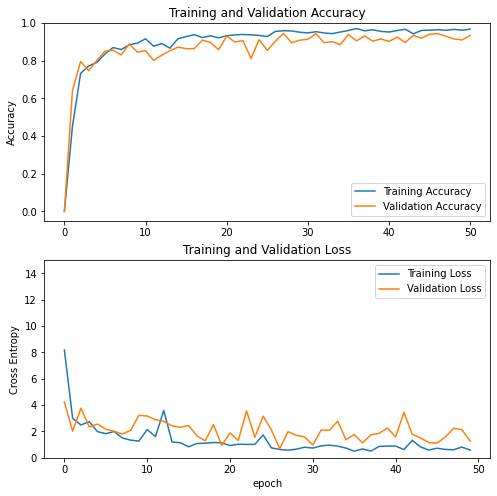

Highest Accuracy: 97.04713225364685%
Highest Validation Accuracy: 94.42970752716064%


In [25]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,15.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
print('Highest Accuracy: {}%'.format(max(history.history['accuracy'])*100))
print('Highest Validation Accuracy: {}%'.format(max(history.history['val_accuracy'])*100))

In [24]:
model.save('/content/drive/MyDrive/Trained Models/MobileNetV2')